In [15]:

import torch
import torchvision
 
#The convolutional neural network will create a bottleneck by doing three convolutions with stride=2,
#halving the sidelength of the "image" each time, quartering the size of the data each time.
#The result should be a compression factor of 64...? I think.
#On 128x128 images, this means a set of 256 features are identified by the CNN (I think)
#This number can be increased or decreased later I guess if need be.
class CNN(torch.nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.compress = torch.nn.Sequential(
            torch.nn.Conv2d(3, 8, 3, padding=1),
            torch.nn.ReLU(False),
            torch.nn.Conv2d(8, 8, 3, padding=1),
            torch.nn.ReLU(False),
            torch.nn.Conv2d(8, 8, 3, stride=2, padding=1), #Compress by 4x
            torch.nn.ReLU(False),
            torch.nn.Conv2d(8, 8, 3, stride=2, padding=1), #Compress by 4x
            torch.nn.ReLU(False),
            torch.nn.Conv2d(8, 8, 3, stride=2, padding=1), #Compress by 4x
            torch.nn.ReLU(False)
        )
        self.decompress = torch.nn.Sequential(
            torch.nn.ReLU(False),
            torch.nn.ConvTranspose2d(8, 8, 3, padding=1),
            torch.nn.ReLU(False),
            torch.nn.ConvTranspose2d(8, 8, 3, padding=1, stride=2, output_padding=1), #Decompress by 4x
            torch.nn.ReLU(False),
            torch.nn.ConvTranspose2d(8, 8, 3, padding=1, stride=2, output_padding=1), #Decompress by 4x
            torch.nn.ReLU(False),
            torch.nn.ConvTranspose2d(8, 3, 3, padding=1, stride=2, output_padding=1), #Decompress by 4x
        )
         
    #We will train the network to predict its own input by compressing and then decompressing it
    def forward(self, input):
        return self.decompress(self.compress(input))
cnn = CNN()

gpu = torch.device('cuda') 
cnn.to(gpu)

adam = torch.optim.Adam(cnn.parameters(), lr=0.001)
transform = torchvision.transforms.Compose([torchvision.transforms.Resize((128, 128)), torchvision.transforms.ToTensor()])
images = torchvision.datasets.ImageFolder('./video_frames', transform=transform)
data_loader = torch.utils.data.DataLoader(dataset=images, batch_size=128, shuffle=True)
loss_function = torch.nn.MSELoss()
 


In [2]:

for epoch in range(30):
    print("Epoch ", end="")
    print(epoch + 1)
    for datum in data_loader:

        frame = datum[0]
        frame = frame.to(gpu) #Put the frame into the GPU

        output = cnn(frame)
        loss = loss_function(output, frame)
        loss.backward()

        adam.step()
        adam.zero_grad()

    print("loss ", end="")
    print(loss)
 
torch.save(cnn.state_dict(), 'cnn.pth')


Epoch 1
loss tensor(0.2529, device='cuda:0', grad_fn=<MseLossBackward0>)
Epoch 2
loss tensor(0.0833, device='cuda:0', grad_fn=<MseLossBackward0>)
Epoch 3
loss tensor(0.0379, device='cuda:0', grad_fn=<MseLossBackward0>)
Epoch 4
loss tensor(0.0274, device='cuda:0', grad_fn=<MseLossBackward0>)
Epoch 5
loss tensor(0.0208, device='cuda:0', grad_fn=<MseLossBackward0>)
Epoch 6
loss tensor(0.0208, device='cuda:0', grad_fn=<MseLossBackward0>)
Epoch 7
loss tensor(0.0208, device='cuda:0', grad_fn=<MseLossBackward0>)
Epoch 8
loss tensor(0.0193, device='cuda:0', grad_fn=<MseLossBackward0>)
Epoch 9
loss tensor(0.0157, device='cuda:0', grad_fn=<MseLossBackward0>)
Epoch 10
loss tensor(0.0155, device='cuda:0', grad_fn=<MseLossBackward0>)
Epoch 11
loss tensor(0.0135, device='cuda:0', grad_fn=<MseLossBackward0>)
Epoch 12
loss tensor(0.0144, device='cuda:0', grad_fn=<MseLossBackward0>)
Epoch 13
loss tensor(0.0137, device='cuda:0', grad_fn=<MseLossBackward0>)
Epoch 14
loss tensor(0.0127, device='cuda:0', g

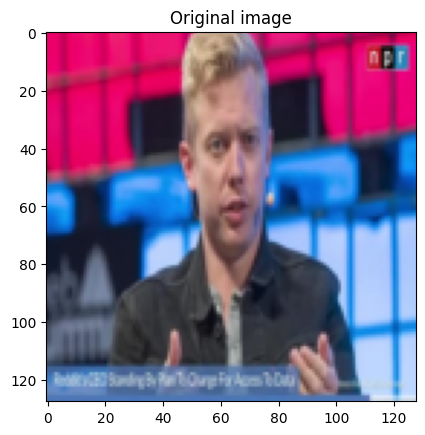

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


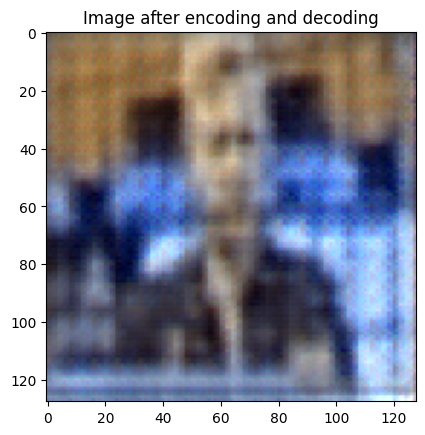

In [23]:
from matplotlib import pyplot
cnn = CNN()
cnn.load_state_dict(torch.load("cnn.pth"))
cnn.eval()
cnn.to(gpu)
with torch.no_grad():
    for data, _ in data_loader:
        data = data.to(gpu)
        recon = cnn(data)
        break
pyplot.title("Original image")
pyplot.imshow(data[0].cpu().permute(1, 2 ,0))
pyplot.show()
pyplot.title("Image after encoding and decoding")
pyplot.imshow(recon[0].cpu().permute(1, 2 ,0))
pyplot.show()

In [29]:
#Now to shove encodings into a database
import psycopg2
import os
#So, we're gonna insert the encodings of about 4,000 frames from the videos into the database
conn = psycopg2.connect(
    host="localhost",
    database="datamining",
    user="msbean",
    password="cactusgreen")

conn.autocommit = True
cursor = conn.cursor() 
  
transform = torchvision.transforms.Compose([torchvision.transforms.Resize((128, 128)), torchvision.transforms.ToTensor()])
images = torchvision.datasets.ImageFolder('./video_frames', transform=transform)
data_loader = torch.utils.data.DataLoader(dataset=images, shuffle=False)

cnn = CNN()
cnn.load_state_dict(torch.load("./cnn.pth"))
encodings = []
with torch.no_grad():
    i = 0
    for data, _ in data_loader:
        sql = "INSERT INTO embeddings (embedding) VALUES ('["
        compress = cnn.compress(data)
        flattened = compress.flatten().tolist()
        for datum in flattened:
            sql += str(datum) + ","
        sql = sql[:-1]
        sql += "]')"
        cursor.execute(sql) 
        i+=1 


conn.commit() 

SELECT id, embedding FROM embeddings ORDER BY embedding <-> '[8.52035140991211,4.073887825012207,4.664942741394043,5.136865139007568,2.1159183979034424,1.0009340047836304,1.628127098083496,1.858610987663269,1.3754000663757324,1.4738188982009888,1.647918462753296,1.6530612707138062,3.924248695373535,5.678164005279541,4.472993850708008,3.2559337615966797,15.143715858459473,11.651527404785156,11.419858932495117,12.988984107971191,8.660625457763672,3.4114813804626465,4.527726173400879,5.092978000640869,5.774233818054199,2.256830930709839,3.862159252166748,5.309426784515381,6.563600063323975,13.389043807983398,5.52330207824707,7.408759593963623,15.171319961547852,12.02023696899414,11.633598327636719,13.091774940490723,10.009417533874512,6.490748405456543,6.446527481079102,7.066493034362793,10.73009967803955,2.3028743267059326,3.7488365173339844,5.6390275955200195,7.625533103942871,13.829355239868164,9.905000686645508,6.678384304046631,15.194272994995117,12.27945327758789,11.747037887573242,

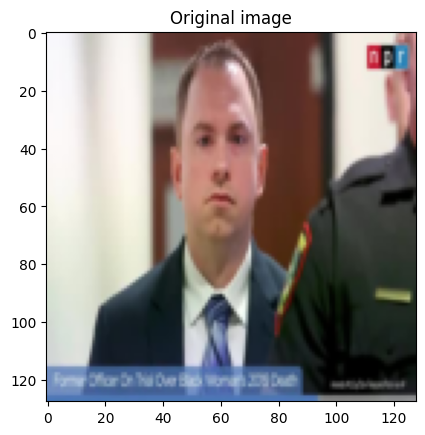

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


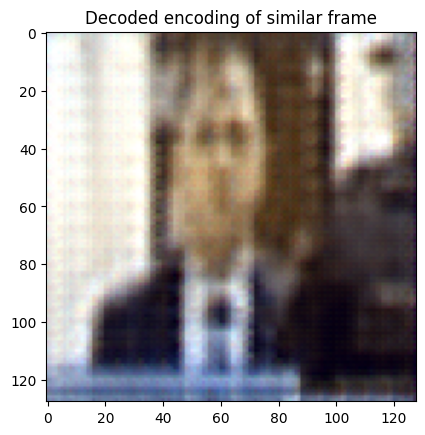

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


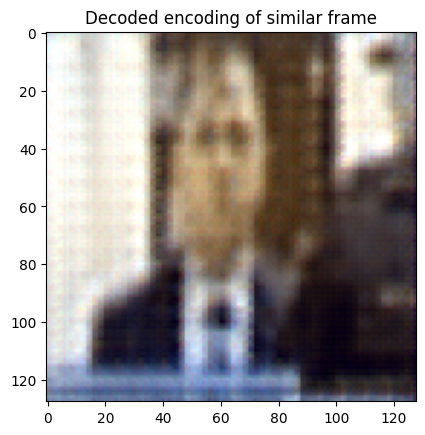

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


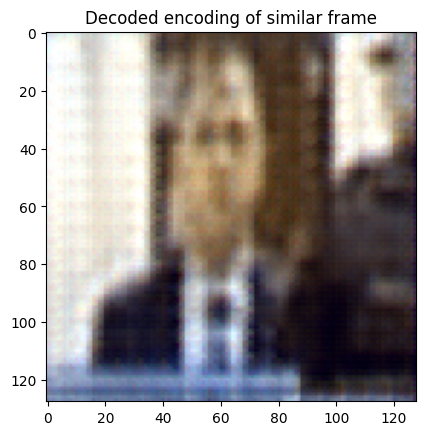

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


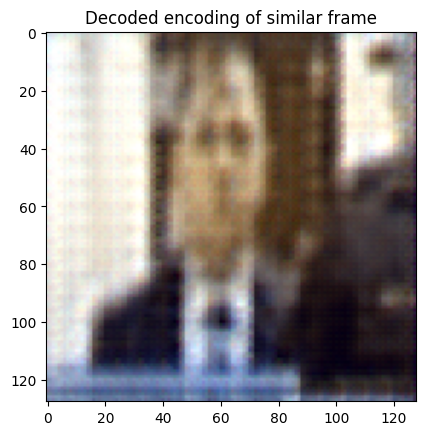

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


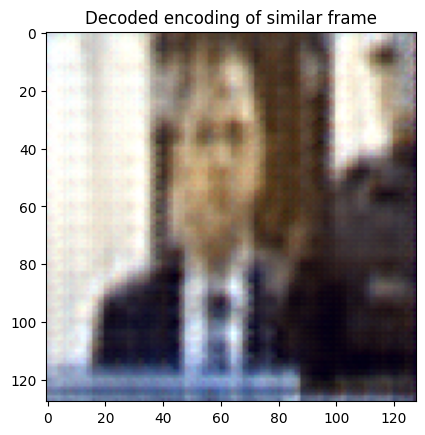

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


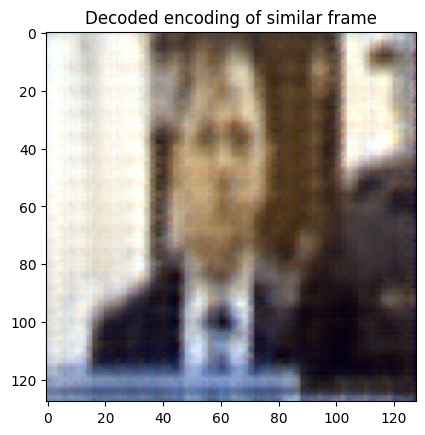

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


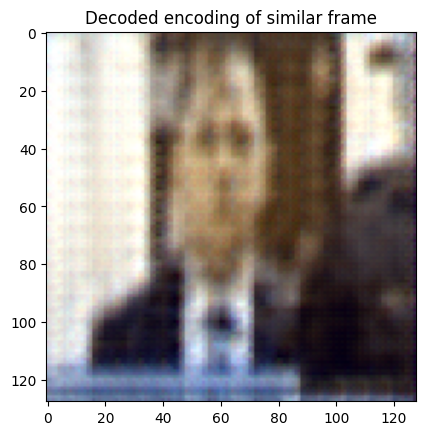

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


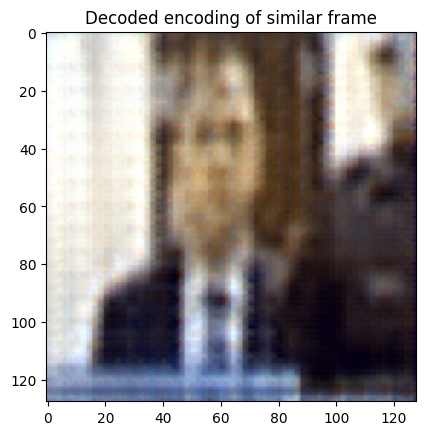

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


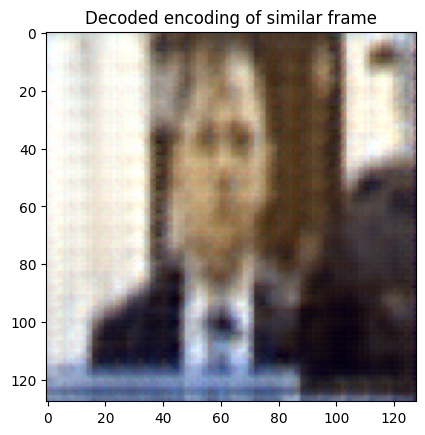

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


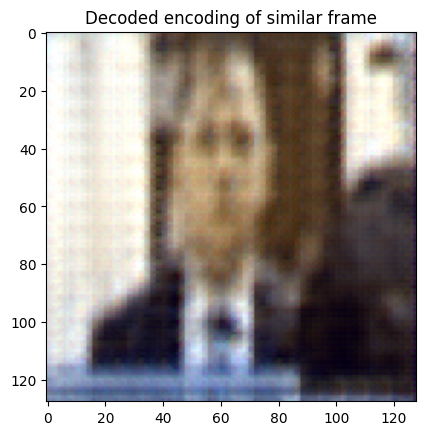

In [30]:
#So, they're in. Now to see if we can't use the <-> operator to get the 10 most similar images to some random image.
#I don't know if I'll have time to figure out how to reconstruct the tensor and decode the images, so just to be safe
#I will have it select the id for now to at least show the id's of the embeddings of the 10 most similar images
#As well as the embeddings

conn = psycopg2.connect(
    host="localhost",
    database="datamining",
    user="msbean",
    password="cactusgreen")

conn.autocommit = True
cursor = conn.cursor() 
with torch.no_grad():
    i = 0
    for data, _ in data_loader:
        if i < 100:
            i += 1
            continue
        sql = "SELECT id, embedding FROM embeddings ORDER BY embedding <-> '["
        compress = cnn.compress(data)
        flattened = compress.flatten().tolist()
        for datum in flattened:
            sql += str(datum) + ","
        sql = sql[:-1]
        sql += "]' LIMIT 10"
        print(sql)
        cursor.execute(sql) 
        records = cursor.fetchall()
        pyplot.title("Original image")
        pyplot.imshow(data[0].cpu().permute(1, 2 ,0))
        pyplot.show()
        for row in records:
            vals = row[1].split(",")
            vals[0] = vals[0][1:]
            vals[len(vals)-1] = vals[len(vals)-1][:-2]
            vals = [float(i) for i in vals]
            reshape = torch.FloatTensor(vals)
            reshape = torch.reshape(reshape, (1, 8, 16, 16))
            recon = cnn.decompress(reshape)
            pyplot.title("Decoded encoding of similar frame")
            pyplot.imshow(recon[0].cpu().permute(1, 2 ,0))
            pyplot.show()
        break


conn.commit() 
conn.close() 
